In [9]:
import tifffile as tiff
import PIL.Image
from cStringIO import StringIO
import IPython.display
import numpy as np

def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

In [4]:
images = tiff.imread('isbi/train-labels.tif')

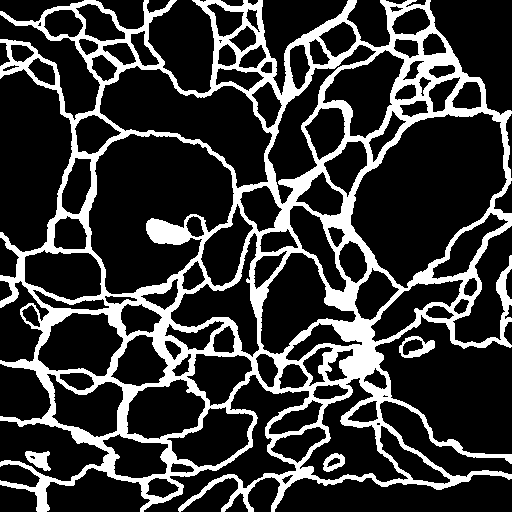

In [72]:
showarray(255-images[0])

In [73]:
from skimage import morphology

In [74]:
skel = morphology.skeletonize_3d(255-images[0])

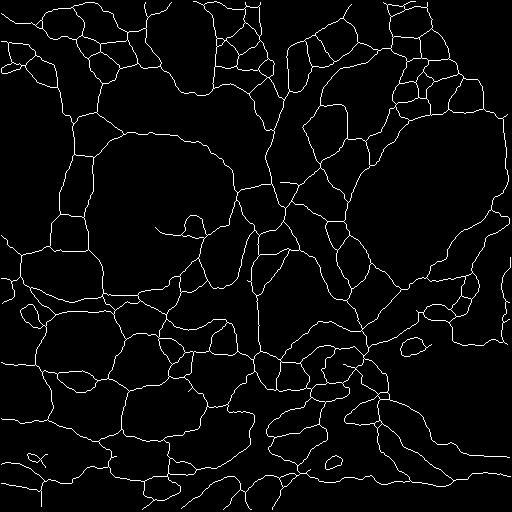

In [75]:
showarray(skel)

In [11]:
from skimage import measure

In [15]:
labels = measure.label(images[0], background=0)

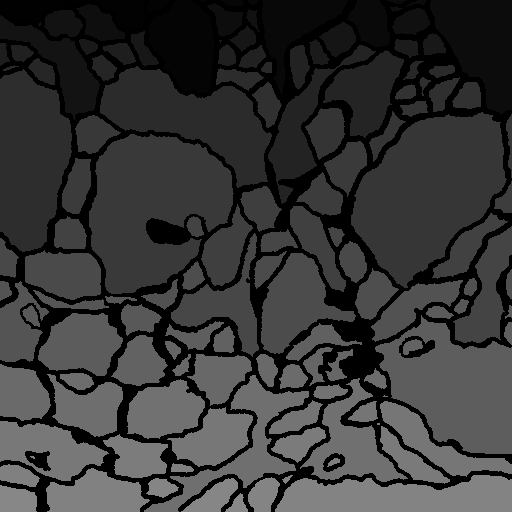

In [16]:
showarray(labels)

In [25]:
import thinning
import cv2

In [31]:
expanded = np.expand_dims(labels, 2)

In [67]:
converted = np.array(expanded, dtype = np.uint8)

In [68]:
thinned = thinning.guo_hall_thinning(converted)

In [69]:
unconverted = np.array(thinned, dtype=np.int64)

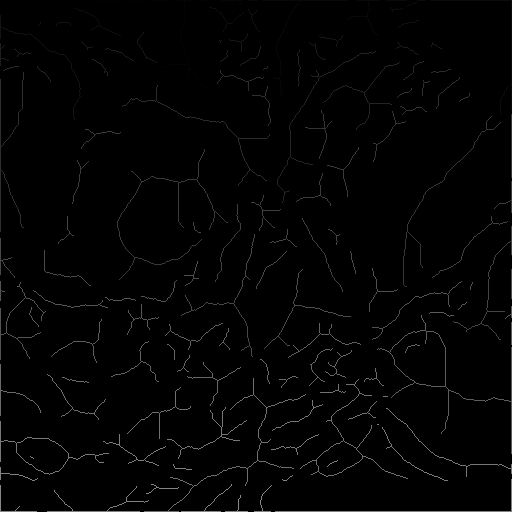

In [70]:
showarray(np.squeeze(unconverted))

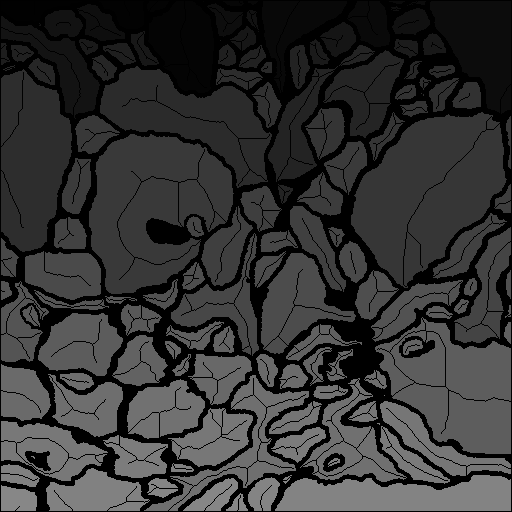

In [57]:
showarray(labels - np.squeeze(unconverted))

In [58]:
size = np.size(converted)
skel = np.zeros(converted.shape,np.uint8)
 
ret,img = cv2.threshold(converted,127,255,0)
element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
done = False
 
while( not done):
    eroded = cv2.erode(img,element)
    temp = cv2.dilate(eroded,element)
    temp = cv2.subtract(img,temp)
    skel = cv2.bitwise_or(skel,temp)
    img = eroded.copy()
 
    zeros = size - cv2.countNonZero(img)
    if zeros==size:
        done = True

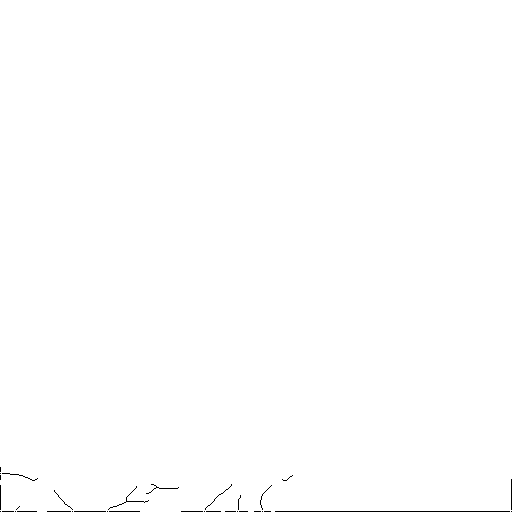

In [1]:
from thirdparty.segascorus import io_utils
from thirdparty.segascorus import utils
from thirdparty.segascorus.metrics import *
    

In [ ]:
# Save affinities to temporary file
# TODO pad the image with zeros so that the output covers the whole dataset
tmp_aff_file = 'validation-tmp-affinities.h5'
tmp_label_file = 'validation-tmp-labels.h5'
ground_truth_file = 'validation-labels.h5'

base = data_folder + 'results/' + model.model_name + '/'

with h5py.File(base + tmp_aff_file, 'w') as output_file:
    output_file.create_dataset('main', shape=(3, num_layers, output_shape, output_shape))
    out = output_file['main']

    reshaped_pred = np.einsum('zyxd->dzyx', sigmoid_prediction)
    out[0:2, :, :, :] = reshaped_pred

# Do watershed segmentation
current_dir = os.path.dirname(os.path.abspath(__file__))
subprocess.call(["julia",
                 current_dir + "/thirdparty/watershed/watershed.jl",
                 base + tmp_aff_file,
                 base + tmp_label_file,
                 str(watershed_high),
                 str(watershed_low)])

In [16]:
import tifffile as tiff
s1 = tiff.imread('isbi/results/validation-map.tif')

In [21]:
tiff.imsave('isbi/results/validation-map-2.tif', s1*255)

In [22]:
s2 = tiff.imread('isbi/results/validation-map-2.tif')
s2

array([[[ 251.87286377,  251.94049072,  252.07061768, ...,  215.7940979 ,
          210.81884766,  216.03475952],
        [ 252.51861572,  252.65682983,  252.61503601, ...,  224.20918274,
          218.66227722,  222.1726532 ],
        [ 252.12644958,  252.44818115,  252.84414673, ...,  238.4037323 ,
          236.19932556,  233.15518188],
        ..., 
        [  68.81265259,   67.32077789,   69.41700745, ...,  254.97875977,
          254.97918701,  254.97996521],
        [  67.6926651 ,   75.83119965,   89.29708099, ...,  254.97697449,
          254.9720459 ,  254.9699707 ],
        [  76.88372803,   88.87463379,   75.80363464, ...,  254.9765625 ,
          254.97608948,  254.97290039]],

       [[ 254.62101746,  254.72677612,  254.68984985, ...,  254.73324585,
          254.68473816,  254.64732361],
        [ 254.71051025,  254.78445435,  254.82588196, ...,  254.62739563,
          254.62106323,  254.6566925 ],
        [ 254.80130005,  254.81217957,  254.79521179, ...,  254.42810059

In [23]:


# Compute rand f score
# --------------------

# Parameters
calc_rand_score = True
calc_rand_error = False
calc_variation_score = True
calc_variation_information = False
relabel2d = True
foreground_restricted = True
split_0_segment = True
other = None

seg1 = io_utils.import_tif('isbi/results/validation-map-2.tif')
seg2 = io_utils.import_tif('isbi/validation-labels.tif')

print(np.max(seg1))

prep = utils.parse_fns(utils.prep_fns,
                       [relabel2d, foreground_restricted])
seg1, seg2 = utils.run_preprocessing(seg1, seg2, prep)

om = utils.calc_overlap_matrix(seg1, seg2, split_0_segment)

# Calculating each desired metric
metrics = utils.parse_fns(utils.metric_fns,
                          [calc_rand_score,
                           calc_rand_error,
                           calc_variation_score,
                           calc_variation_information])

results = {}
for (name, metric_fn) in metrics:
    if relabel2d:
        full_name = "2D {}".format(name)
    else:
        full_name = name

    (f, m, s) = metric_fn(om, full_name, other)
    results["{} Full".format(name)] = f
    results["{} Merge".format(name)] = m
    results["{} Split".format(name)] = s

print('Rand F-Score Full: ' + str(results['Rand F-Score Full']))
print('Rand F-Score Split: ' + str(results['Rand F-Score Split']))
print('Rand F-Score Merge: ' + str(results['Rand F-Score Merge']))
print('VI F-Score Full: ' + str(results['VI F-Score Full']))
print('VI F-Score Split: ' + str(results['VI F-Score Split']))
print('VI F-Score Merge: ' + str(results['VI F-Score Merge']))


254
Relabeling segments for 2d metrics...
number of segments: 255-->763
number of segments: 2-->4
Performing foreground-restriction
Finding overlap matrix...
Completed in 0.106394 seconds
Calculating 2D Rand F-Score...
Completed in 0.000902 seconds
Calculating 2D VI F-Score...
Completed in 0.000488 seconds
Rand F-Score Full: 0.354227041117
Rand F-Score Split: 0.215234452119
Rand F-Score Merge: 1.0
VI F-Score Full: 0.414812436585
VI F-Score Split: 0.26168035011
VI F-Score Merge: 1.0


In [11]:
seg1.shape

(631964,)